# Import

In [63]:
import warnings
warnings.filterwarnings("ignore")

In [64]:
import time
from time import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch
from torch import  nn, optim
import torchvision.models as models
from torchvision import transforms, datasets
from torchvision.models import swin_v2_t, swin_v2_b
from torch.utils.data import DataLoader

import loralib

from utils import save_model, save_plots, SaveBestModel

# Working Folder

In [65]:
# Get the current working directory
current_directory = os.getcwd()

train_dir = os.path.join(current_directory, "../ISIC2019_train/Image_DullRazor")
val_dir = os.path.join(current_directory, "../ISIC2019_valDR")
print(train_dir)
print(val_dir)

/home/user/Dat/Vit/lora/Swin_From_Scratch/../ISIC2019_train/Image_DullRazor
/home/user/Dat/Vit/lora/Swin_From_Scratch/../ISIC2019_valDR


## Check num workers and gpu

In [66]:
NUM_WORKERS = os.cpu_count()
total_images = 0
for i in os.listdir(train_dir):
    tmp = os.path.join(train_dir, i)
    for j in os.listdir(tmp):
        total_images += 1
print(total_images)
NUM_WORKERS

20264


12

# Dataset

In [67]:
IMG_SIZE = 32
# IMG_SIZE = 224


def create_dataloaders(
    train_dir: str, 
    val_dir: str,
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
    
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
        #                      std=[0.229, 0.224, 0.225])
        ])    
    
    valid_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], 
        #                      std=[0.229, 0.224, 0.225])
        ]) 

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=train_transform)
    val_data = datasets.ImageFolder(val_dir, transform=valid_transform)
    
    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
    )
    val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
    )

    return train_dataloader, val_dataloader, class_names

## Create data loader

In [68]:
BATCH_SIZE = 32

# Create data loaders
train_dataloader, val_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    val_dir=val_dir,
    # transform=manual_transforms, 
    batch_size=BATCH_SIZE,
    num_workers=1
)

train_dataloader, val_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fb28d6d1160>,
 ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'])

## Class weight

In [7]:
# Calculate class Weight
class_weights = []
for i in os.listdir(train_dir):
    tmp = os.path.join(train_dir, i)
    total_in_folder = 0
    for j in os.listdir(tmp):
        total_in_folder += 1
    
    tmp_weight = 1 - (total_in_folder / total_images)
    class_weights.append(round(tmp_weight,3))
class_weights = torch.Tensor(class_weights)
print(class_names)
print(class_weights)

['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
tensor([0.8210, 0.4920, 0.9750, 0.8690, 0.9660, 0.9900, 0.9910, 0.8960])


# Plot sample

In [53]:
def visualize_batch(batch, classes, dataset_type):
	# initialize a figure
	fig = plt.figure("{} batch".format(dataset_type),
		figsize=(BATCH_SIZE, BATCH_SIZE))
	# loop over the batch size
	for i in range(0, BATCH_SIZE-25):
		# create a subplot
		ax = plt.subplots(1, 1)
		# grab the image, convert it from channels first ordering to
		# channels last ordering, and scale the raw pixel intensities
		# to the range [0, 255]
		image = batch[0][i].cpu().numpy()
		image = image.transpose((1, 2, 0))
		image = (image * 255.0).astype("uint8")
		# grab the label id and get the label from the classes list
		idx = batch[1][i]
		label = classes[idx]
		# show the image along with the label
		plt.imshow(image)
		plt.title(label)
		plt.axis("off")
	# show the plot
	plt.tight_layout()
	plt.show()

[INFO] visualizing training batch...


<Figure size 3200x3200 with 0 Axes>

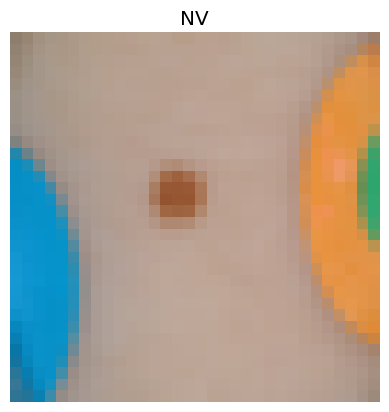

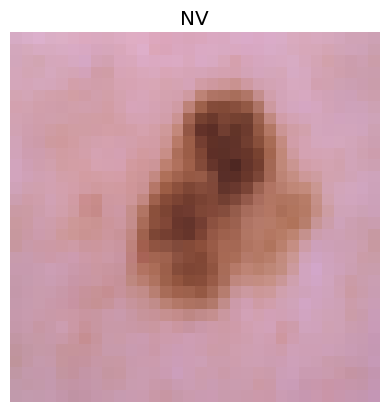

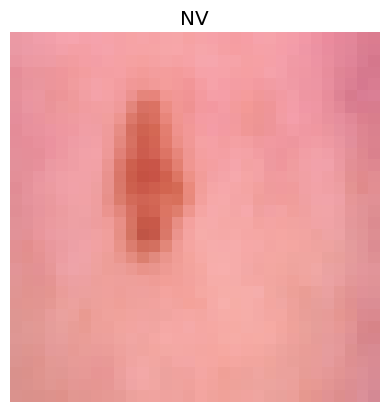

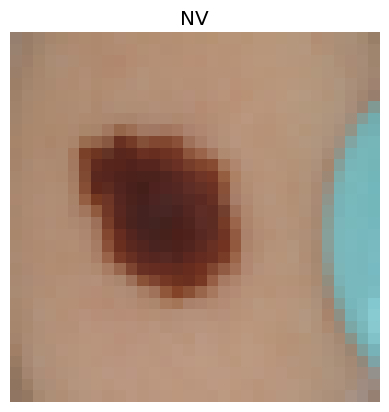

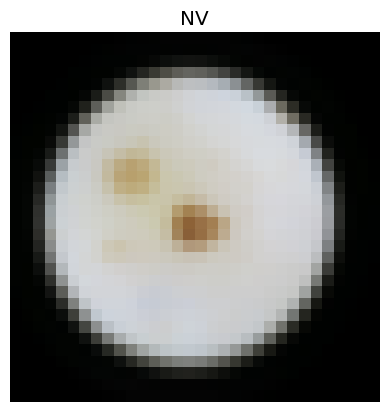

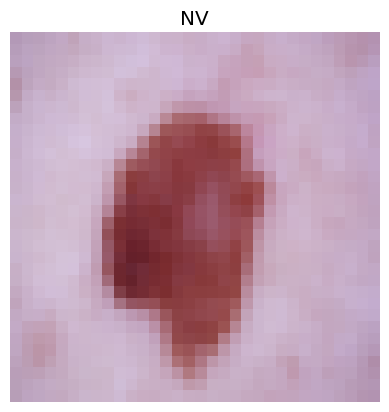

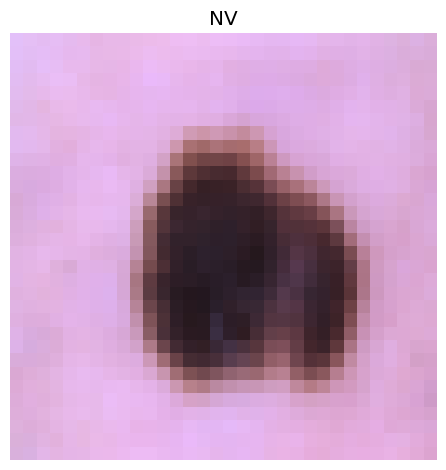

[INFO] visualizing validation batch...


<Figure size 3200x3200 with 0 Axes>

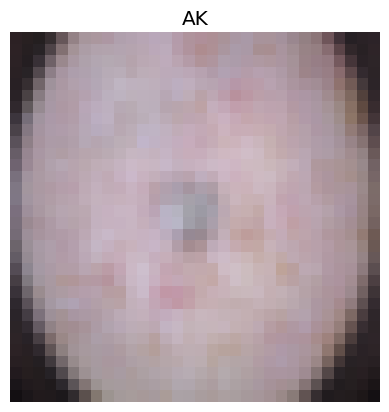

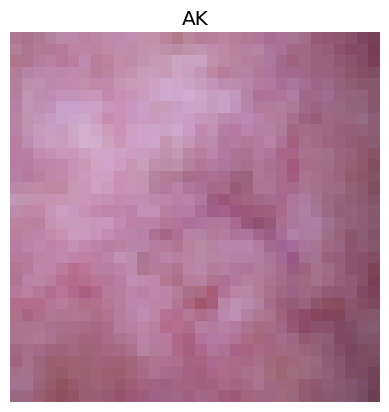

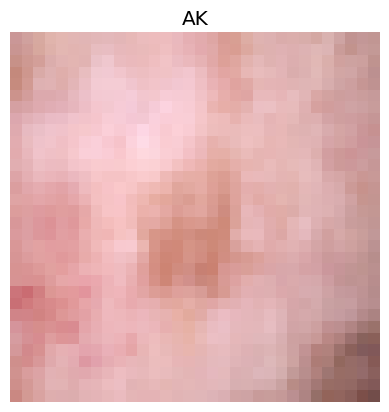

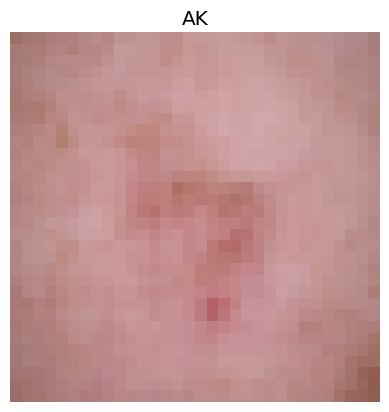

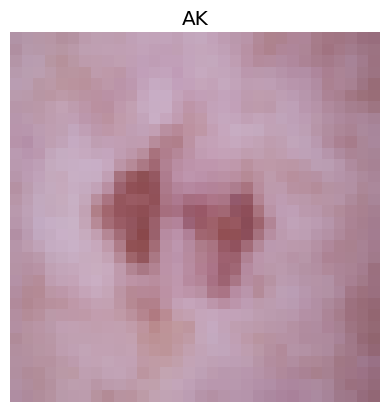

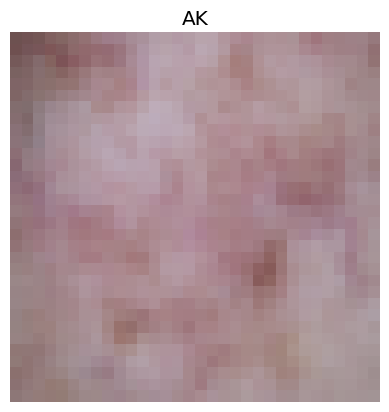

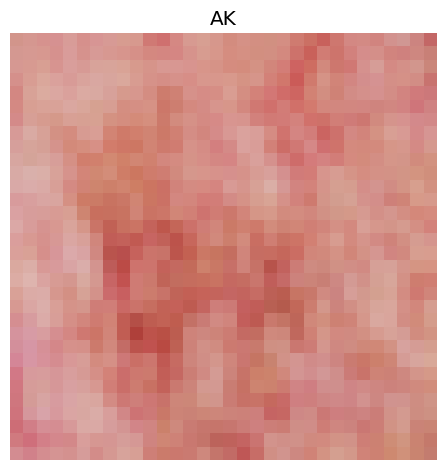

In [54]:
trainBatch = next(iter(train_dataloader))
valBatch = next(iter(val_dataloader))
# visualize the training and validation set batches
print("[INFO] visualizing training batch...")
visualize_batch(trainBatch, class_names, "train")
print("[INFO] visualizing validation batch...")
visualize_batch(valBatch, class_names, "val")

Feature batch shape: torch.Size([32, 3, 32, 32])
Labels batch shape: torch.Size([32])


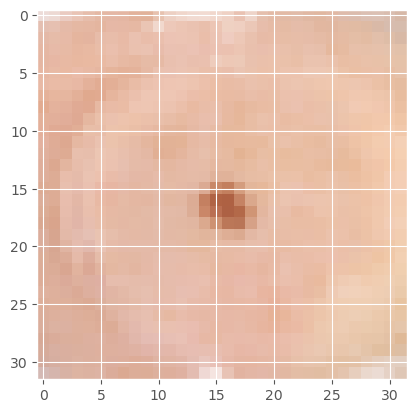

Label: 5


In [41]:
# Display image and label.
# for i in train_dataloader:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")



# Check GPU

In [69]:
# Move the model to the GPU if available
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(len(class_names))
device

8


device(type='cuda', index=0)

# Init Model

In [72]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.GELU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = loralib.Linear(8192, 512, r=32)
        self.act3 = nn.GELU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = loralib.Linear(512, 8, r=32)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
    
model = CNN()

model = model.to(device)

In [59]:
from torchsummary import summary
summary(model, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           9,248
              GELU-5           [-1, 32, 32, 32]               0
         MaxPool2d-6           [-1, 32, 16, 16]               0
           Flatten-7                 [-1, 8192]               0
            Linear-8                  [-1, 512]       4,194,816
              GELU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                    [-1, 8]           4,104
Total params: 4,209,064
Trainable params: 10,144
Non-trainable params: 4,198,920
----------------------------------------------------------------
Input size (MB): 0.01

## Total param and optimizer

In [60]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss(
    label_smoothing=0.11 ,
    weight=class_weights
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)

4,504,232 total parameters.
305,832 training parameters.


# Training

In [ ]:
# model = CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 500
for epoch in range(n_epochs):
    tq = tqdm(total=len(train_dataloader) * BATCH_SIZE, position=0, leave=True)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, n_epochs))
    
    for inputs, labels in train_dataloader:
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
 
    acc = 0
    count = 0
    for inputs, labels in val_dataloader:
        y_pred = model(inputs)
        acc += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    acc /= count
    print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))